# Stoachastic Block model experiments
\author Calvin Roth





# Block Stochastic Information
In this case assume we know by some means the exact comunity structure to use and the probability of a link from one community to another with perfect clarity. We will compare the profits generated to that of the ideal system when you know every individial node. 

In the code `A_av` is a realization of the block model where instead of having a 1 with chance $P_{ij}$ we set the value in the matrix to $P_{ij}$
We compare this to the uniform price and the true optimal price. 

In [1]:
def part_from_cluster(cluster):
    n_groups = len(set(cluster))
    n = len(cluster)
    P = np.zeros((n_groups, n))
    for i in range(n):
        label = cluster[i]
        P[label, i] = 1 
    return P 

def profit_with_part(G, part, a, c, rho):
    n = len(G)
    B =  inv(np.eye(n, n ) - 2*rho*G )
    one = np.ones((n,1))
    price = part.T @ inv(part @ (B+B.T)@ part.T) @ part @ (a*B + c*B.T)@one 
    profit = 0.125 *(a-c)*(a-c)* (price -c*one).T @ B @ (a*one - price)
    return profit

In [2]:
### Set up
import numpy as np 
from numpy.linalg import norm, inv
from helperfunctions.util import stoch_block, build_constraint, aver_stoch_block
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
a = 6
c = 4
dim = 4
prob_mat = np.zeros((dim,dim))
np.random.seed(22956)
for i in range(dim):
    for j in range(dim):
        prob_mat[i,j] = np.random.random()


ModuleNotFoundError: No module named 'matplotlib'

## KMeans

In [142]:
n = 600
block_sizes = [n for i in range(dim)]
mat =   prob_mat
G = stoch_block(block_sizes, mat)
rho = 0.9/norm(G+G.T, ord=2)
one = np.ones((dim*n,1))
B =  inv(np.eye(n*dim, n*dim ) - 2*rho*G )

In [143]:
import sklearn.cluster as skclust 
clusters = []
for i in range(1,dim+10):
    cluster = skclust.KMeans(n_clusters=i,n_init=50).fit_predict(G)
    clusters.append(cluster)


In [144]:
P = np.kron(np.eye(dim,dim), np.ones((n,1)))
price = P@ inv(P.T @(B+B.T)@ P) @ P.T @(a*B + c*B.T)@one
0.5 * (price - c*one).T @ B @ (a*one - price)

array([[23833.76004441]])

In [145]:
profits = []
a = 6
c = 4
for cl in clusters:
    P = part_from_cluster(cl)
    profits.append(profit_with_part(G, P, a, c, rho)[0][0])
opt_profit = 0.125 *(a-c)*(a-c) * one.T @ inv(np.eye(dim*n, dim*n ) - rho*(G+G.T) ) @ one 
opt_profit


array([[23846.3676746]])

In [146]:
table = pd.DataFrame()
table["N Communities"] = np.array([i for i in range(1,dim+10)])
table["Profit"] = profits
table

,N Communities,Profit
0,1,20738.149342
1,2,22237.243741
2,3,23008.028221
3,4,23203.038185
4,5,23485.095165
5,6,23525.094008
6,7,23810.580306
7,8,23833.760044
8,9,23833.767704
9,10,23833.760593


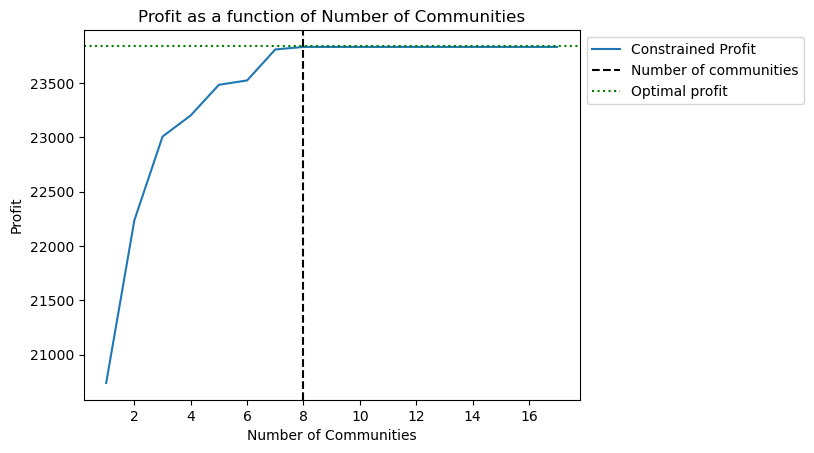

In [147]:
fig, ax = plt.subplots()
ax.plot([i for i in range(1,dim+10)], profits, label="Constrained Profit")
ax.axvline(dim, color="black", linestyle="--", label="Number of communities")
ax.axhline(opt_profit, color="green", linestyle=":",label="Optimal profit")
ax.set_xlabel("Number of Communities")
ax.set_ylabel("Profit")
ax.set_title("Profit as a function of Number of Communities")
ax.legend(loc=0, bbox_to_anchor=(1,1))

In [140]:
opt_profit

array([[29763.22329864]])

## Numerical Experiments

In [56]:
rhop = 0.9/norm(prob_mat+prob_mat.T,ord=2)
Bp = inv(np.eye(dim,dim) - 2*rhop*prob_mat)
one4 = np.ones((4,1))
price_2 = inv(Bp +Bp.T) @ (a*Bp + c*Bp.T)@one4
consumption = 0.5 * Bp @ (a*one4 - price_2)
profit = (price_2 - c*one4).T @ consumption 
profit*200

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 8)

In [3]:
Ns = [i*200 for i in range(1,8)]
uni_prof = []
opt_prof = []
comm_prof = []
const = (a-c)*(a-c)/8
n_trials = 5
for n in Ns:
    uni_ave = []
    opt_ave = [] 
    comm_ave = [] 
    for t in range(n_trials):
        print(n)
        block_sizes = [n for i in range(dim)]
        G = stoch_block(block_sizes, prob_mat)
        G_av = aver_stoch_block(block_sizes, prob_mat)
        rho = 0.9/norm(G+G.T, ord=2)
        rho_av = 0.9/norm(G_av + G_av.T, ord=2)
        B =  inv(np.eye(n*dim, n*dim ) - 2*rho*G )
        B_av = inv(np.eye(n*dim, n*dim) - 2*rho_av*G_av)
        opt_term = inv(np.eye(n*dim, n*dim) - rho*(G+G.T))
        one = np.ones((dim*n,1))
        one_small = np.ones((dim, 1))
        P = np.zeros( (n*dim, dim))
        P[0:n, 0] = 1
        for i in range(1, dim):
            P[i*n:(i+1)*n, i] = 1
        uni_ave.append( (const * one.T @ B @ one)[0][0]  )
        opt_ave.append( (const * one.T @ opt_term @ one)[0][0])
        comm_price = P @ inv(P.T @ (B + B.T) @ P ) @  P.T @ (a*B + c*B.T) @ one
        consumption = 0.5 * B @ (a*one - comm_price)
        profit = (comm_price - c*one).T @ consumption 
        comm_ave.append(profit[0][0])
    uni_prof.append(uni_ave)
    comm_prof.append(comm_ave)
    opt_prof.append(opt_ave)


200
200
200
200
200
400
400
400
400
400
600
600
600
600
600
800
800
800
800
800
1000
1000
1000
1000
1000
1200
1200
1200
1200
1200
1400
1400
1400
1400
1400


In [29]:
mean_uni = [np.mean(uni_prof[i]) for i in range(7)]
mean_opt = [np.mean(opt_prof[i]) for i in range(7)]
mean_comm = [np.mean(comm_prof[i]) for i in range(7)]
max_uni = [np.max(uni_prof[i]) for i in range(7)]
max_opt = [np.max(opt_prof[i]) for i in range(7)]
max_comm = [np.max(comm_prof[i]) for i in range(7)]
min_uni = [np.min(uni_prof[i]) for i in range(7)]
min_opt = [np.min(opt_prof[i]) for i in range(7)]
min_comm = [np.min(comm_prof[i]) for i in range(7)]
uni_err = np.zeros((2,7))
opt_err = np.zeros((2,7))
comm_err = np.zeros((2,7))
uni_err[1, :] = [max_uni[i] - mean_uni[i] for i in range(7)]
uni_err[0, :] = [mean_uni[i]-min_uni[i]  for i in range(7)]
opt_err[1, :] = [max_opt[i] - mean_opt[i] for i in range(7)]
opt_err[0, :] = [mean_opt[i]-min_opt[i]  for i in range(7)]
comm_err[1, :] = [max_comm[i] - mean_comm[i] for i in range(7)]
comm_err[0, :] = [mean_comm[i]-min_comm[i]  for i in range(7)]



In [35]:
mean_uni

[2655.565574463364,
 5307.90160298345,
 7968.829547080454,
 10629.876342272537,
 13287.64452452772,
 15942.223056052917,
 18603.494872088148]

In [33]:
uni_err,  comm_err, opt_err

(array([[5.8796029 , 3.64943284, 4.61412862, 2.86915631, 7.26718354,
         4.036388  , 1.74999277],
        [4.35428038, 3.59261557, 3.26127451, 2.74197739, 6.18006628,
         3.51764933, 2.11176425]]),
 array([[1.65704382, 0.90955895, 0.48453939, 0.7916837 , 0.93081761,
         0.999602  , 1.14761875],
        [1.11890585, 1.4910273 , 0.41933097, 1.29377297, 1.0124119 ,
         1.54827926, 1.03699592]]),
 array([[0.47324296, 1.11727733, 0.80407733, 0.44535651, 0.72963016,
         1.0724944 , 1.16903493],
        [0.53728804, 0.64973453, 0.59664941, 0.80736253, 0.7456415 ,
         0.85570688, 1.08380937]]))

<ErrorbarContainer object of 3 artists>

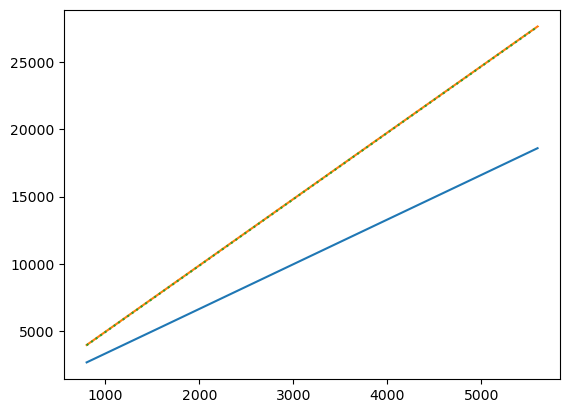

In [31]:
fig, ax = plt.subplots()
Ms = [4*i for i in Ns]
ax.errorbar(Ms, mean_uni,yerr=uni_err )
ax.errorbar(Ms, mean_opt,yerr=opt_err )
ax.errorbar(Ms, mean_comm,yerr=comm_err, linestyle="dotted" )

#ax.plot(Ms, uni_prof, label="Uniform")
#ax.plot(Ms, opt_prof, label="Optimal")
#ax.plot(Ms, comm_prof, "go", label="Community Pricing")
#ax.set_xlabel("Number of Nodes")
#ax.set_ylabel("Profit")
#ax.set_title("Profit as a function of Network size")
#ax.legend()

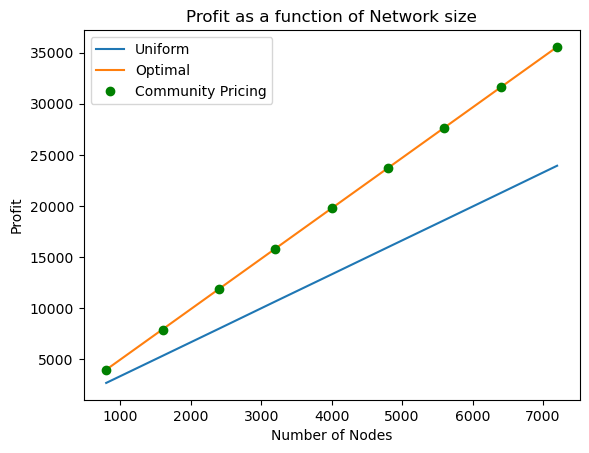

In [13]:
fig, ax = plt.subplots()
Ms = [4*i for i in Ns]
ax.plot(Ms, uni_prof, label="Uniform")
ax.plot(Ms, opt_prof, label="Optimal")
ax.plot(Ms, comm_prof, "go", label="Community Pricing")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Profit")
ax.set_title("Profit as a function of Network size")
ax.legend()

In [8]:
regret_uniform = [1 - (uni_prof[i]/opt_prof[i]) for i in range(len(opt_prof)) ]
regret_comm = [1 - (comm_prof[i]/opt_prof[i]) for i in range(len(opt_prof))]

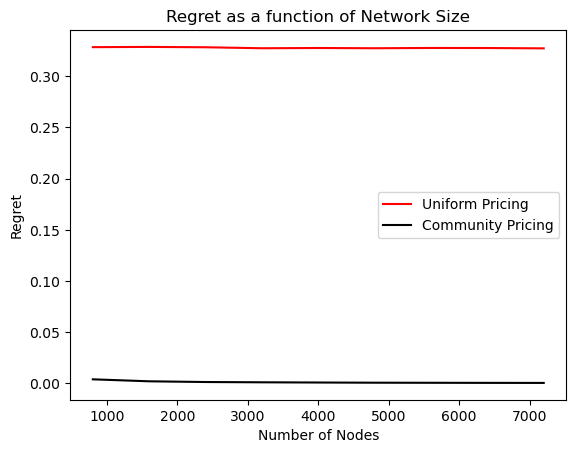

In [20]:
fig, ax = plt.subplots()
ax.plot(Ms, regret_uniform, "r", label="Uniform Pricing")
ax.plot(Ms, regret_comm, "k", label="Community Pricing")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Regret")
ax.set_title("Regret as a function of Network Size")
ax.legend()

In [21]:
regret_uniform

[0.3283789058171003,
 0.32860191268100447,
 0.32827404747764966,
 0.3273110942337789,
 0.3275475439075286,
 0.3273150093368212,
 0.32757816408668206,
 0.32753058217204145,
 0.32720238485032294]

## Example
Here we take the hierarchical model with a fixed core size and fixed uniform branching factor and examine the effect of a varying uniform density in the each layer


## Setup

In [3]:
import networkx as nx
import numpy as np
from numpy.linalg import inv, cond,norm
import numpy.linalg as lin 
from scipy.linalg import svdvals 
import matplotlib.pyplot as plt
import helperfunctions.util
a = 6
c = 4

def make_n_layer(core, inner_weights, branching_factors):
    sizes = [ core ]
    cores = [ core ]
    for i in range(1, len(inner_weights)+1):
        sizes.append(sizes[i-1] * branching_factors[i-1])
        cores.append(cores[i-1] + sizes[i])
    n = sum(sizes)
    G = np.zeros((n,n))
    cur = sizes[0]
    for i in range(cores[0]):
        for j in range(inner_weights[0]):
            k = (i + j+1) % core
            G[i,k] = 1
        for j in range(branching_factors[0]):
            G[i, cur] = 1
            cur += 1
    for layer in range(1, len(inner_weights)  ):
        for i in range(cores[layer-1], cores[layer] ):
            for j in range(inner_weights[layer]):
                k = i + j  + 1 
                if(k >= cores[layer]):
                    overflow = k - cores[layer]
                    k = cores[layer - 1] + overflow
                    #print(n, k, j)
                G[i, k] = 1
            for j in range(branching_factors[layer]):
                G[i, cur] = 1
                cur += 1 
    ## Add in loop from last to first node
    #for node in range(cores[-2], cores[-1]):
    #    G[node, node % cores[0]] = 1
    return cores, G 


cores, G = make_n_layer(2, [1,1], [2,2])
n = cores[-1]
I = np.eye(n,n)
rho = 0.95 / norm(G + G.T, ord=2)
B = inv(I - 2 * rho * G)

def slice(i, cores):
    n = cores[-1]
    slc = np.zeros((n,))
    if(i == 0):
        slc[0:cores[0]] = 1
        return slc 
    slc[cores[i-1]: cores[i]] = 1
    return slc 
    
def build_constraint(cores, B, a, c):
    n = len(cores)
    G = np.zeros((n,n))
    v = np.zeros((n,1))
    ones = np.ones((cores[-1],1))
    for i in range(n):
        for j in range(n):
            G[i,j] = slice(i, cores).T @ B @ slice(j, cores) + slice(j, cores).T @ B @ slice(i, cores)
        v[i] = a * slice(i, cores).T @ B @ ones + c * ones.T @ B @ slice(i, cores)
    return G, v

def price_from_small(cores, block_map, prices):
    n  = cores[-1]
    v = np.zeros((n,1))
    v[0:cores[0]] = prices[ block_map[0]]
    for i in range(1, len(cores)):
        v[cores[i-1]: cores[i]] = prices[ block_map[i]]
    return v 



ModuleNotFoundError: No module named 'matplotlib'

In [4]:
def profit_from_spec(core, inner_weights, branching_factors):
    cores, G = make_n_layer(core, inner_weights, branching_factors)
    n = cores[-1]
    I = np.eye(n,n)
    rho = 0.95 / norm(G + G.T, ord=2)
    B = inv(I - 2 * rho * G)
    A, v = build_constraint(cores, B, a, c)
    small_prices = inv(A) @ v 
    price = price_from_small(cores, [i for i in range(len(cores))], small_prices)
    ones = np.ones((n,1))
    profit = 0.5 * (price - c*ones).T @ B @ (a*ones - price)
    print(a,c)
    return profit[0,0], price, B 

cores, G = make_n_layer(4, [2,2], [2,2])
rho = 0.95 / norm(G + G.T, ord=2)
print((helperfunctions.util.optProfit(G, rho, a, c) - profit_from_spec(4, [2,2], [2,2])[0]))

NameError: name 'make_n_layer' is not defined

In [5]:
def profit_from_spec(core, inner_weights, branching_factors):
    cores, G = make_n_layer(core, inner_weights, branching_factors)
    n = cores[-1]
    I = np.eye(n,n)
    rho = 0.95 / norm(G + G.T, ord=2)
    B = inv(I - 2 * rho * G)
    A, v = build_constraint(cores, B, a, c)
    small_prices = inv(A) @ v 
    price = price_from_small(cores, [i for i in range(len(cores))], small_prices)
    ones = np.ones((n,1))
    profit = 0.5 * (price - c*ones).T @ B @ (a*ones - price)
    print(a,c)
    return profit[0,0], price, B 


## Making the graph 


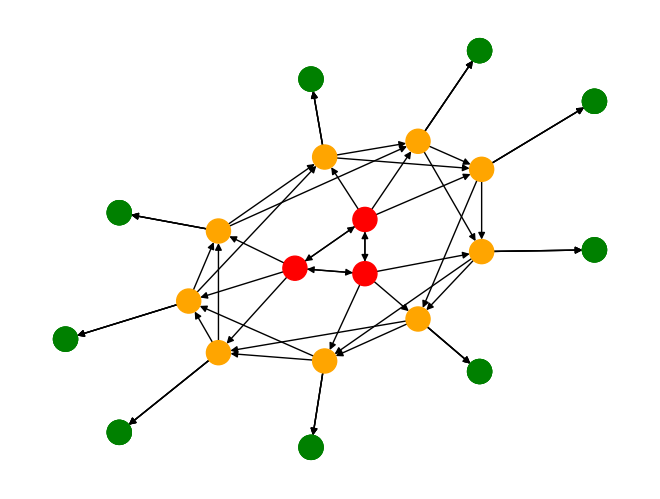

In [42]:
cores, G =  make_n_layer(3, [2,2], [3,3])
color_map = []
for i in range(cores[-1]):
    if(i < cores[0]):
        color_map.append("red")
    elif(i < cores[1]):
        color_map.append("orange")
    elif(i < cores[2]):
        color_map.append("green")
    elif(i < cores[3]):
        color_map.append("blue")
color_map2 = ["white" for i in range(cores[-1])]
colors = ["red", "blue", "green"]
def color_in(start, cores, color, G, layer, result):
    n = len(G)
    for j in range(n):
        if(j >= cores[layer] and G[start, j]==1):
            result[j] = color 
            color_in(j, cores, color, G, layer +1, result)
    return result 

for i in range(3):
    color_map2[i] = colors[i]
    color_in(i, cores, colors[i], G, 0, color_map2)
            
nx.draw_spectral(nx.DiGraph(G), node_color = color_map)



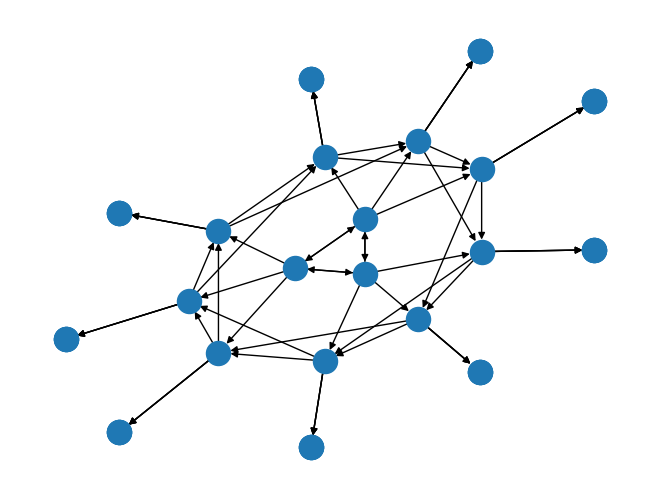

In [41]:
nx.draw_spectral(nx.DiGraph(G))


Next we find the optimal price without constraints, the optimal price with constraints, and the profits of each

In [45]:
n = len(G)
ones = np.ones((n,1))
rho = 0.9/ norm(G+G.T, ord=2)
B = 0.5*inv(np.eye(n,n) - 2*rho*G)
opt_price = inv(B+B.T) @ (a*B + c*B.T) @ ones 
opt_profit = (opt_price - c*ones).T @ B @ (a*ones - opt_price)

print("The optimal price is")
print(opt_price)

The optimal price is
[[10.01526718]
 [10.01526718]
 [10.01526718]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.94656489]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]
 [ 3.32824427]]


And this generates a profit of 

In [46]:
opt_profit

array([[108.77862595]])

Same for the partitioned price now

In [47]:
part = np.zeros((3,n))
part[0, :3] = 1
part[1,3:12] = 1
part[2,12:] = 1
part_price = part.T @ inv(part @ (B+B.T) @ part.T) @ part @ (a*B + c*B.T) @ ones 
part_profit = (part_price - c*ones).T @ B @ (a*ones - part_price)

The charge to each block is

In [48]:
part_price

array([[10.01526718],
       [10.01526718],
       [10.01526718],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.94656489],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427],
       [ 3.32824427]])

And these are the same

In [50]:
norm(part_price - opt_price, ord=1)

1.4921397450962104e-13

And the profit is 

In [51]:
part_profit

array([[108.77862595]])

In [67]:
a = 6
c = 4
dim = 4
prob_mat = np.zeros((dim,dim))
np.random.seed(22956)
for i in range(dim):
    for j in range(dim):
        prob_mat[i,j] = np.random.random()

n = 200 
block_sizes = [n for i in range(dim)]
M = np.log2(n*4)/(n*4) * prob_mat
G = stoch_block(block_sizes, M)

(0.0055828125, 0.0036387050593046015)

In [68]:
n = len(G)
ones = np.ones((n,1))
rho = 0.9/ norm(G+G.T, ord=2)
B = 0.5*inv(np.eye(n,n) - 2*rho*G)
opt_price = inv(B+B.T) @ (a*B + c*B.T) @ ones 
opt_profit = (opt_price - c*ones).T @ B @ (a*ones - opt_price)

opt_profit

array([[3463.98886212]])

In [69]:
n = len(G)
ones = np.ones((n,1))
rho = 0.9/ norm(G+G.T, ord=2)
B = 0.5*inv(np.eye(n,n) - 2*rho*G)
uni_price = 0.5 * (a+c)* ones 
uni_profit = (uni_price - c*ones).T @ B @ (a*ones - uni_price)

uni_profit

array([[1608.95125339]])

In [70]:
P = np.kron(np.eye(dim,dim), np.ones((200,1)))

In [71]:
opt_price = P @ inv(P.T@(B+B.T)@P) @ P.T @ (a*B + c*B.T) @ ones 
#opt_profit = (opt_price - c*ones).T @ B @ (a*ones - opt_price)

opt_profit

array([[3463.98886212]])

In [72]:
P.shape

(800, 4)

In [76]:
np.sum(G)

3573.0

In [78]:
M

array([[0.00932176, 0.00288618, 0.00507271, 0.00721126],
       [0.00749351, 0.00323622, 0.0077978 , 0.01177522],
       [0.00253105, 0.0004412 , 0.0036371 , 0.00322408],
       [0.00365855, 0.00826813, 0.00916597, 0.0026821 ]])

### More datasets

In [2]:
import numpy as np
import pandas as pd 
from numpy.linalg import norm, inv


In [63]:

fil = open("data/email-Eu-core.txt").readlines()
n = 1005
data = np.zeros((n,n))
for line in fil[4:]:
    line = line.replace(" \n","")
    a,b  = line.split(' ')
    data[int(a), int(b)] = 1

In [61]:

fil = open("data/p2p-Gnutella08.txt").readlines()
n = 6301
data = np.zeros((n,n))
for line in fil[4:]:
    line = line.replace(" \n","")
    a,b  = line.split('\t')
    data[int(a)-1, int(b)-1] = 1
    #if(int(weight) >= 3):
    #    data[int(a)-1, int(b)-1] = 1

In [64]:
a = 6 
c = 4 
rho = 0.95 / norm(data + data.T, ord=2)

In [65]:
a = 6 
c = 4 
rho = 0.95 / norm(data + data.T, ord=2)
B = inv(np.eye(n,n) - 2*rho*data)
opt_price = inv(B+B.T) @ (a*B + c*B.T) @ np.ones((n,))
uni_price = 0.5 * (a+c) * np.ones((n,1))

opt_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- rho*(data + data.T)) @ np.ones((n,1))
uni_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- 2*rho*data ) @ np.ones((n,1))

opt_profit, uni_profit

(array([[4002.84990678]]), array([[3106.9687824]]))

In [66]:
fil = open("data/email-Eu-core-department-labels.txt" ).readlines()
part = np.zeros((42, n))
for line in fil:
    line = line.replace(" \n","")
    a,b  = line.split(' ')
    part[int(b), int(a)] = 1

In [67]:
a = 6 
c = 4 

block_price = part.T @ inv(part @ (B+B.T) @ part.T )  @ part @  (a*B + c*B.T) @ np.ones((n,1))
block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
block_profit, opt_profit, uni_profit

(array([[3195.30422448]]), array([[4002.84990678]]), array([[3106.9687824]]))

In [69]:
import sklearn.cluster as skclust 
n_cl = 25

cluster =  skclust.KMeans(n_clusters=n_cl,n_init=50).fit_predict(data)


In [70]:
part = np.zeros((n_cl, n))
for i in range(n):
    cl = cluster[i]
    part[cl, i] = 1 
block_price = part.T @ inv(part @ (B+B.T) @ part.T )  @ part @  (a*B + c*B.T) @ np.ones((n,1))
block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
block_profit, opt_profit, uni_profit

(array([[3271.74076541]]), array([[4002.84990678]]), array([[3106.9687824]]))

## Notes 
1. Tried Kmeans clustering with 25 nodes. Better than using given ground truth for email set 
## Questions 
1. How does $\rho$ after the relative gaps in performance? 
2. in the networks disinformation, a person starts with prior $\delta$ and recieves signal $s$ after reading. Why is updated belief $\frac{\delta s}{\delta s + (1-\delta)(1-s)}$

In [7]:
centrality_vec =  (data -data.T) @ inv(np.eye(n,n)- rho*(data + data.T)) @ np.ones((n,))


NameError: name 'percentiles' is not defined

In [95]:
#percentiles = [1,2,3,4,5, 10,30, 50, 70 ,90, 95, 96, 97, 98, 99]
percentiles = [ 50, 75]
#step = 100/23
#percentiles = [i*step for i in range(1,23)]
ts = [np.percentile(opt_price,p) for p in percentiles] 
m_bins = len(ts) 
part = np.zeros((m_bins+1, n))
part[0, :] = np.where(opt_price <= ts[0], 1, 0)
for i in range(1, m_bins):
    part[i, :] = np.where( (opt_price <= ts[i]) 
                           & (opt_price > ts[i-1]),
                            1, 0 )
part[m_bins] = np.where( opt_price > ts[-1], 1, 0)


In [96]:
len(np.sum(part, axis=1))

3

In [97]:
list(np.where(part[0] == 1)[0])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 20,
 22,
 23,
 25,
 28,
 30,
 33,
 34,
 37,
 40,
 41,
 44,
 46,
 47,
 49,
 50,
 52,
 53,
 55,
 56,
 57,
 58,
 61,
 62,
 68,
 70,
 76,
 78,
 79,
 81,
 83,
 84,
 85,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 101,
 102,
 103,
 105,
 106,
 107,
 113,
 114,
 116,
 117,
 118,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 132,
 133,
 136,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 160,
 162,
 163,
 165,
 167,
 169,
 170,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 186,
 187,
 189,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 211,
 212,
 213,
 214,
 215,
 218,
 219,
 220,
 221,
 222,
 223,
 226,
 229,
 230,
 232,
 233,
 234,
 236,
 237,
 238,
 239,
 240,
 241,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 263,
 264,
 265,
 267,
 268,
 270,
 271,
 273,
 274,
 280,
 281,


In [98]:
G = nx.Graph(data+data.T)

In [99]:
sub_graphs = []
labels = []
for i in range(len(part)):
    sub =  G.subgraph(np.where(part[i] == 1)[0] )
    print(len(sub), nx.number_connected_components(sub))


3152 2290
1574 899
1575 32


In [82]:
s1 = sub_graphs[0]
s2 = sub_graphs[1]
combined =  np.where( (part[0] == 1) | (part[1] == 1))[0]
s3 = G.subgraph(combined)
print(nx.number_connected_components(s1), len(s1))
print(nx.number_connected_components(s2), len(s2))
print(nx.number_connected_components(s3), len(s3))
nx.connected_components(s1)

3 64
59 63
12 127


TypeError: 'generator' object is not subscriptable

In [11]:
block_price = part.T @ inv(part @ (B+B.T) @ part.T ) @ part @  (a*B + c*B.T) @ np.ones((n,1))

In [12]:
block_price = part.T @ inv(part @ (B+B.T) @ part.T ) @ part @  (a*B + c*B.T) @ np.ones((n,1))
block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
block_profit, opt_profit, uni_profit

(array([[5443.69923134]]), array([[6096.82446086]]), array([[4085.37376481]]))

In [13]:
100 * (1 - (block_profit[0,0]/opt_profit[0,0]))

10.712547715708244

In [14]:
100 * (1 - (uni_profit/ opt_profit))

array([[32.99177644]])

In [15]:
m_bins

15

In [16]:
degrees = np.sum(data, axis=1) + np.sum(data, axis=0) 
unique_degrees = list(set(degrees))

In [17]:
xs = []
prs = []
for degree in unique_degrees:
    xs.append( degree)
    t =   np.sum(np.where(degrees == degree, 1, 0))
    prs.append( t/n  )

In [18]:
2 * np.sum(data)/(n*(n-1))

0.0010467978123905755

In [19]:
np.log2(n)/n

0.002003073336663206

Text(0, 0.5, 'Frequency')

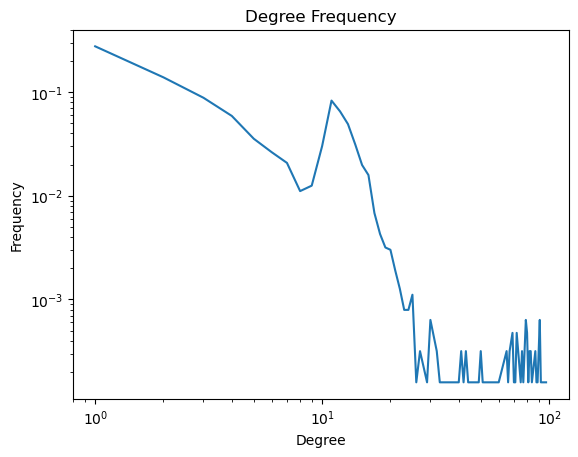

In [20]:
plt.loglog(xs, prs)
plt.title("Degree Frequency")
plt.xlabel("Degree")
plt.ylabel("Frequency")

In [ ]:
def merge_components(compons, prices):
    

In [21]:

plt.hist(centrality_vec * ,  bins=63, )

SyntaxError: invalid syntax (273930600.py, line 1)

In [22]:
np.max( np.absolute(centrality_vec))

692.1662472694959

In [23]:
import networkx.algorithms.community as nx_comm
from communities.algorithms import louvain_method

d = data + data.T 
H = nx.Graph(d)

In [24]:
comms =  nx_comm.louvain_communities(H)

In [25]:
m = len(comms)

In [29]:
len(comms)

21

In [27]:
part = np.zeros((m, n))
for j in range(len(comms)):
    for i in comms[j]:
        part[j, i] = 1 

In [28]:
block_price = part.T @ inv(part @ (B+B.T) @ part.T ) @ part @  (a*B + c*B.T) @ np.ones((n,1))
block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
block_profit, opt_profit, uni_profit

(array([[4086.57907917]]), array([[6096.82446086]]), array([[4085.37376481]]))

In [349]:
len(np.sum(part, axis=1))

22

In [357]:
opt_price = inv(B+B.T) @ (a*B + c*B.T) @ np.ones((n,))
uni_price = 0.5 * (a+c) * np.ones((n,1))

opt_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- rho*(data + data.T)) @ np.ones((n,1))
uni_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- 2*rho*data ) @ np.ones((n,1))

opt_profit, uni_profit

(array([[6096.82446086]]), array([[4085.37376481]]))

In [356]:
a, c, rho

(6, 4, 0.03171754419846024)

In [51]:
nx_comm.modularity(G, comms)

0.4663289799370687

In [54]:
comms2 = [ ]
for i in range(len(part)):
    comms2.append( list(np.where(part[i] == 1 )[0]))

In [59]:
nx_comm.modularity(G, comms2)

-0.030148291736981355

1. Find components: connected components of nodes in the same price graph 
2. Merge small communties to those they most links to 
    or Communities they have the closest price to 
3. How to quantize is tricky. 

In [137]:
A = np.zeros((15,15))
A[0:5, 5:15] = 1
colors = ["red" for i in range(5)] + ["blue" for j in range(5,15)]

In [138]:
A[0,:]

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [139]:
G = nx.DiGraph(A)

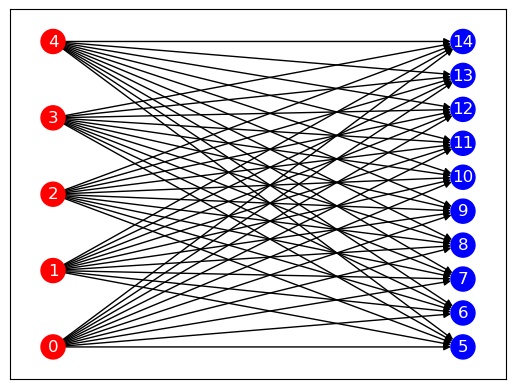

In [140]:
l = nx.layout.bipartite_layout(G, [0,1,2,3,4])
nx.draw_networkx(G, pos=l, node_color=colors, font_color="white")

## Other data

In [66]:
import numpy as np 
import networkx as nx 
from numpy.linalg import norm, inv
import scipy
import pandas as pd 
import networkx.algorithms.community as nx_comm
G = nx.read_gml("data/polblogs.gml")
G = nx.DiGraph(G)
H = nx.Graph(G)


In [67]:
data = nx.adjacency_matrix(G).todense()

/var/folders/19/v976smp1427fy96lbd0y82ym0000gn/T/ipykernel_15181/1352410357.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  data = nx.adjacency_matrix(G).todense()


In [90]:
a = 6 
c = 4 
rho = 0.90 / norm(data + data.T, ord=2)
n = len(data)
B = inv(np.eye(n,n) - 2*rho*data)
opt_price = inv(B+B.T) @ (a*B + c*B.T) @ np.ones((n,))
uni_price = 0.5 * (a+c) * np.ones((n,1))

opt_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- rho*(data + data.T)) @ np.ones((n,1))
uni_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- 2*rho*data ) @ np.ones((n,1))

opt_profit, uni_profit

(matrix([[2470.42671449]]), matrix([[1280.56133721]]))

In [91]:
# values = nx.get_node_attributes(G , "value")
# n = len(nx.get_node_attributes(G , "value"))
# part = np.zeros((2,n))
# j = 0
# for i in values:
#     value = values[i] 
#     part[value, j] = 1
#     j += 1 

comms = nx_comm.louvain_communities(nx.Graph(data+data.T))
part = np.zeros((len(comms), n))
for j in range(len(comms)):
    for i in comms[j]:
        part[j, i] = 1

In [92]:
np.sum(part, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

In [93]:
block_price = part.T @ inv(part @ (B+B.T) @ part.T ) @ part @  (a*B + c*B.T) @ np.ones((n,1))
block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
block_profit, opt_profit, uni_profit

(matrix([[1280.59654364]]),
 matrix([[2470.42671449]]),
 matrix([[1280.56133721]]))

In [108]:
d = open("data/protiens.txt").readlines()
n = 1706 
data = np.zeros((n,n))
for i in range(n):
    s = d[i].replace(" \n","")
    s1 ,s2 = s.split(" ")
    s1 = int(s1)-1
    s2 = int(s2)-1
    data[s1,s2] = 1


0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19
20 21
22 23
24 25
12 26
27 28
29 30
31 32
33 34
35 36
37 38
39 40
41 42
4 43
44 19
45 46
47 48
49 50
51 52
53 54
6 9
55 56
57 58
59 60
61 62
63 64
65 66
67 68
69 6
70 71
72 73
74 75
76 77
66 78
79 80
81 82
83 84
85 86
87 48
88 89
90 91
92 93
94 95
96 97
98 99
100 101
102 103
104 105
106 76
66 107
108 109
110 72
111 84
112 113
114 115
116 117
118 63
119 120
121 53
122 123
124 125
126 127
128 129
130 131
132 133
134 135
38 136
137 138
7 139
140 141
142 12
143 144
145 146
34 112
147 148
149 150
151 49
10 152
153 10
154 82
155 156
141 157
158 159
160 10
35 161
162 163
164 149
165 10
166 167
168 169
170 171
172 173
49 174
175 17
176 177
178 179
117 180
181 182
183 184
185 4
50 49
81 186
30 187
169 168
188 189
190 191
49 192
193 194
195 196
197 198
199 200
201 202
62 203
204 115
205 206
207 208
209 210
211 212
213 214
149 215
100 216
156 155
121 91
32 195
217 218
219 220
221 222
223 224
225 226
227 228
221 14
221 229
62 210
230 231
232 233
23

In [109]:
a = 6 
c = 4 
rho = 0.90 / norm(data + data.T, ord=2)
n = len(data)
B = inv(np.eye(n,n) - 2*rho*data)
opt_price = inv(B+B.T) @ (a*B + c*B.T) @ np.ones((n,))
uni_price = 0.5 * (a+c) * np.ones((n,1))

opt_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- rho*(data + data.T)) @ np.ones((n,1))
uni_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- 2*rho*data ) @ np.ones((n,1))

opt_profit, uni_profit

(array([[1759.66411994]]), array([[1345.0147254]]))